# Leveraging Python & Jupyter Notebook to validate satellite Ocean Color retrievals
### Joel P Scott
NASA GSFC<br>OB.DAAC / SeaBASS
#### International Ocean Colour Science Meeting
##### 2019-04-09, Breakout Workshop

<div><img style="float: right;" src='./figs/nasa_meatball_rgb-online.png', width=400px, height=400px></div>

# My Coding Background
* Formally trained in: FORTRAN and C

* During graduate school: Maple, MATLAB, Mathematica, GrADS, & IDL

* Early career: FORTRAN (processing/speed) and MATLAB (visualization & analysis)

* But...
    * MATLAB is costly after school
    * Toolboxes not always portable (collaboration, reproducibility, etc)

# Summer 2014
* Two colleagues and I: all new code would be written in Python

* Still had MATLAB, if needed
    * But rarely did

* By the end of the summer, Python was my language of choice.

# Why Python?
* Open-source license
* Multi-platform interoperability &rarr; Windows, Mac, & Linux
* Established language
    * Existed since the late 80s
    * Popular among web, app developers, & data science communities
    * Well-documented online, with a major <a href="https://stackoverflow.com">StackOverflow</a> presence

* Versatile modules for tons of application
    * Machine learning
    * Data processing, analysis, & visualization
    * Database queries
    * HTTPS requests
    * JSON parsing, etc


# My Setup
* Package manager: <a href="https://www.anaconda.com/distribution/">Anaconda</a>
* Frequently used modules
    * NumPy (vector arithmetic functions)
    * Xarray and/or pandas (array & dataset manipulation, netCDF support)
    * Matplotlib (MATLAB-esque plots & more)

Python can be executed on the command line, via a script, or in an IDE (Integrated Development Environment).
* <a href="https://jupyter.org">Jupyter Notebook</a>
    * Runs in a browser
    * Cells are individually executable
    * Supports Markdown
    * Help prompts (tab-suggestions & shift-tab doc-string)
    * Supports in-line plots
    * Exportable as .py, .pdf, .tex, .html, etc

* Runs Reveal.js via <a href="https://damianavila.github.io/RISE/usage.html">RISE</a>

In [1]:
import time
from User_Defined import regress2, avg_duplicate_matchups, download_file
import subprocess
from math import isnan
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from pathlib import Path

%matplotlib inline

verbose = False #set to True for debugging subprocess cmds

dir_dat = Path('./data') #dir for in situ data
dir_tmp = Path('./tmp') #temp dir for satellite granules

url_insitu = 'https://seabass.gsfc.nasa.gov/archive_preview/BIGELOW/BALCH/FERRY_02/archive/s020710w/main-s020710w.txt'
file_sb = Path(download_file(url_insitu, str(dir_dat)))

# Why I'm a fan of Python

Example:
<br>
<table>
  <td>
      <ol>
          <li>Start with an *in situ* data file, in the SeaBASS format, Gulf of Maine, Scotia-Prince Ferry (Balch, 2002)</li>
          <li>Find coincident Ocean Color satellite granules</li>
          <li>Extract satellite data and pair it to the in situ data<br>(matchups!)</li>
          <li>Derive "goodness-of-fit" metrics</li>
          <li>Plot the matchup data (2-ways)</li>
      </ol>
  </td>
  <td>
    <img src='./figs/map_s020710w.png' width=500px />
  </td>
</table>

## What is SeaBASS?
<a href="https://seabass.gsfc.nasa.gov">SeaBASS</a> is a bio-optical data archive at NASA's OB.DAAC<br>(<a href="https://earthdata.nasa.gov/about/daacs/daac-obdaac">Ocean Biology Distributed Active Archive Center</a>).
<center><img src='./figs/sb_homepage.png', width=1500px></center>

## What is a SeaBASS file?
<table>
    <td>
        <ul>
            <li>Self-describing ASCII data file</li>
            <li>Metadata headers</li>
            <li>Delimited (comma, space, or tab) data matrix</li>
        </ul>
    </td>
    <td>
        <img src='./figs/sb_file.png', width=500px>
    </td>
</table>

## Making a matchup

* Leverage SeaBASS's stand-alone satellite validation matchup<a href="https://seabass.gsfc.nasa.gov/wiki/seabass_tools#Satellite%20Validation%20Match-up%20Tools"> scripts</a>
    * Written in Python 3
    * Avaliable via NASA <a href="https://seadas.gsfc.nasa.gov">SeaDAS</a> software

<center><img src='./figs/matchup_tools.png', width=1500px></center>

## 1. Find matching satellite granules: <font color='blue'>fd_matchup.py</font>

* Inputs
    * SeaBASS file: Gulf of Maine Scotia-Prince Ferry data (Balch, 2002)
    * Satellite instrument: MODIS-Aqua
    * Data type: <a href="https://oceancolor.gsfc.nasa.gov/products/#product_suite">Ocean Color</a> satellite product suite &rarr; *Chl* retrievals via OCI algorithm

* Actions
    * Locates coincident Level-2 satellite granules
    * via NASA's <a href="https://search.earthdata.nasa.gov/search">Earthdata Search</a>'s CMR API (nominally within +/- 3 hrs)

* Outputs
    * List of granules & their URLs
    * Download matching netCDF granules

In [2]:
cmd_find = 'fd_matchup.py --sat modisa --data_type oc --seabass_file ' + \
            str(file_sb) + ' --get_data ' + str(dir_tmp)

%time pid = subprocess.run(cmd_find, stdout=subprocess.PIPE, stderr=subprocess.PIPE, \
                     encoding='ascii', shell=True)

print('\nSTDOUT:\n',pid.stdout)

CPU times: user 12.8 ms, sys: 15.2 ms, total: 28 ms
Wall time: 6min 39s

STDOUT:
 Matching AQUA/MODIS granule (A2002191170500.L2_LAC_OC.nc) found for: data/main-s020710w.txt
SUCCESS!
 
Matching AQUA/MODIS granule (A2002191184000.L2_LAC_OC.nc) found for: data/main-s020710w.txt
SUCCESS!
 
Number of granules found: 2
 



In [3]:
if pid.stderr:
    
    print(pid.stdout)
    print(pid.stderr)
    
if verbose:
    
    print(pid.stdout)

## 2. Pair satellite data to in situ targets: <font color='blue'>mk_matchup.py</font>

* Inputs
    * SeaBASS file
    * One (or more) L2 satellite granules

* Actions
    * Extract & pair satellite data to in situ data
    * Applies exclusion criteria from Bailey & Werdell (2006)
        * 5x5 pixel extract
        * Greater than 50% valid pixels
        * Solar zenith angle less than 70&deg; & satellite zenith angle less than 60&deg;
        * Max time difference +/- 3 hours
        * Max coefficient of variation less than 0.15

* Output: appends satellite matchups to SeaBASS file as additional columns

In [4]:
lis_datasat = sorted(list(dir_tmp.glob('*.nc')))

cmd_make = 'mk_matchup.py' + \
           ' --seabass_file ' + str(file_sb) + \
           ' --sat_file ' + ' '.join([str(fname_L2) for fname_L2 in lis_datasat])

%time pid = subprocess.run(cmd_make, stdout=subprocess.PIPE, stderr=subprocess.PIPE, \
                     encoding='ascii', shell=True)

print('\nSTDOUT:\n',pid.stdout)

CPU times: user 7.36 ms, sys: 9.53 ms, total: 16.9 ms
Wall time: 4min

STDOUT:
 Looking for satellite/in situ match-ups for: data/main-s020710w.txt
Checking: tmp/A2002191170500.L2_LAC_OC.nc
Satellite/in situ match-up(s) found.
Checking: tmp/A2002191184000.L2_LAC_OC.nc
No valid satellite match-ups found.
 



In [5]:
if pid.stderr:
    
    print(pid.stdout)
    print(pid.stderr)
    
if verbose:
    
    print(pid.stdout)

In [6]:
for ifile in lis_datasat:
    
    ifile.unlink()

## 3. Load and plot matchup data from SeaBASS file

* Via the <a href="https://seabass.gsfc.nasa.gov/wiki/readsb_python">SeaBASS Python module</a> (SB_support.py)
    * readSB class

In [7]:
from SB_support import readSB

ds = readSB(filename=file_sb, mask_missing=True, no_warn=True)

* Loads entire SeaBASS file using native Python structures
    * metadata headers
    * auxillary comments
    * fields/units
    * data matrix

In [8]:
for key in ds.variables:
    print(ds.variables[key])

('year', 'yyyy')
('month', 'mo')
('day', 'dd')
('hour', 'hh')
('minute', 'mn')
('second', 'ss')
('lat', 'degrees')
('lon', 'degrees')
('wt', 'degreesc')
('sal', 'psu')
('bb470', '1/m')
('bb514', '1/m')
('bb676', '1/m')
('chl', 'mg/m^3')
('agp412', '1/m')
('agp440', '1/m')
('agp488', '1/m')
('agp510', '1/m')
('agp555', '1/m')
('agp630', '1/m')
('agp650', '1/m')
('agp676', '1/m')
('agp715', '1/m')
('ag412', '1/m')
('ag440', '1/m')
('ag488', '1/m')
('ag510', '1/m')
('ag555', '1/m')
('ag630', '1/m')
('ag650', '1/m')
('ag676', '1/m')
('ag715', '1/m')
('c412', '1/m')
('c440', '1/m')
('c488', '1/m')
('c510', '1/m')
('c555', '1/m')
('c630', '1/m')
('c650', '1/m')
('c676', '1/m')
('c715', '1/m')
('es412.4', 'uw/cm^2/nm')
('es441.6', 'uw/cm^2/nm')
('es490.6', 'uw/cm^2/nm')
('es508.9', 'uw/cm^2/nm')
('es553.6', 'uw/cm^2/nm')
('es671.0', 'uw/cm^2/nm')
('es683.5', 'uw/cm^2/nm')
('lt412.7', 'uw/cm^2/nm/sr')
('lt441.5', 'uw/cm^2/nm/sr')
('lt491.0', 'uw/cm^2/nm/sr')
('lt510.8', 'uw/cm^2/nm/sr')
('lt55

In [9]:
print('\n'.join(ds.comments[:35]))

 original_file_name=s020710w.txt

 bb514 values have been corrected for instrument biofouling.
 ac9 values have been corrected for temperature, salinity and biofouling of the instrument.


 Pre cruise bb514 for HPLC water was 0.000682
 Post cruise bb514 for HPLC water was 0.0008068

 ac9 water calibrations
 Channel     Precruise        Postcruise
 a412        -0.000815        -0.000815
 a440        -0.013657        -0.013657
 a488        -0.030516        -0.030516
 a510        -0.031062        -0.031062
 a555        -0.034711        -0.034711
 a630        -0.037208        -0.037208
 a650        -0.034883        -0.034883
 a676        -0.048446        -0.048446
 a715        -0.020361        -0.020361
 c412        -0.001934        -0.001934
 c440        -0.005771        -0.005771
 c488        -0.009803        -0.009803
 c510        -0.007209        -0.007209
 c555        -0.006925        -0.006925
 c630        -0.002497        -0.002497
 c650        -0.004811        -0.004811
 c676      

In [10]:
print(ds.length)
print(ds.data['sal'])

266
[31.79, 31.73, 31.81, 31.84, 31.87, 31.82, 31.81, 31.78, 31.82, 31.83, 31.81, 31.85, 31.99, 31.96, 32.09, 32.17, 31.95, 31.92, 32.2, 32.3, 32.23, 32.28, 32.44, 32.45, 32.47, 32.5, 32.54, 32.5, 32.52, 32.52, 32.45, 32.39, 32.4, 32.28, 32.25, 32.24, 32.24, 32.25, 32.2, 32.21, 32.24, 32.18, 32.17, 32.15, 32.14, 32.14, 32.16, 32.17, 32.16, 32.16, 32.15, 32.14, 32.14, 32.12, 32.12, 32.13, 32.12, 32.11, 32.1, 32.1, 32.11, 32.11, 32.1, 32.1, 32.1, 32.08, 32.06, 32.05, 32.04, 32.03, 32.03, 32.03, 32.03, 32.03, 32.03, 32.03, 32.04, 32.03, 32.03, 32.02, 32.02, 32.02, 32.02, 32.02, 32.02, 32.01, 32.01, 32.01, 32.02, 32.02, 32.02, 32.03, 32.04, 32.05, 32.04, 32.04, 32.04, 32.04, 32.04, 32.05, 32.04, 32.03, 32.03, 32.03, 32.02, 32.02, 32.02, 32.03, 32.04, 32.03, 32.04, 32.04, 32.04, 32.05, 32.05, 32.04, 32.04, 32.04, 32.04, 32.04, 32.03, 32.03, 32.02, 32.03, 32.04, 32.04, 32.04, 32.04, 32.04, 32.04, 32.05, 32.06, 32.07, 32.07, 32.06, 32.07, 32.06, 32.06, 32.05, 32.05, 32.05, 32.07, 32.07, 32.06

Matchup: where both in situ & satellite data are valid on the same row

In [11]:
chl_sat    = [] #list to contain satellite matchup values
chl_insitu = [] #list to contain in situ matchup values

for chl_sat_i,chl_insitu_i in zip(ds.data['modis_aqua_chlor_a'], ds.data['chl']):
    
    if not isnan(chl_sat_i) and not isnan(chl_insitu_i):
        chl_insitu.append(chl_insitu_i)
        chl_sat.append(chl_sat_i)

[chl_insitu, chl_sat] = avg_duplicate_matchups(chl_insitu, chl_sat) #average together in situ targets within same satellite pixel

## 4. Compute goodness-of-fit statistics
* Chlorophyll is log-normally distributed &rarr; Multiplicative metrics (Seegers et al, 2018)

* Mean bias
<center><img src='./figs/MeanBias_multiplicative.png', width=500px></center>

In [12]:
bias = 10**np.mean([a - b for a,b in zip(np.log10(chl_sat), np.log10(chl_insitu))])

* Mean absolute error (MAE)
<center><img src='./figs/MAE_multiplicative.png', width=500px></center>

In [13]:
from sklearn.metrics import mean_absolute_error

mae = 10**mean_absolute_error(np.log10(chl_insitu), np.log10(chl_sat))

* Linear regression slope
    * Ordinary Least Squares (OLS) Reduced Major Axis (RMA)

In [14]:
linreg_rma = regress2(np.asarray(chl_insitu), np.asarray(chl_sat), \
                      _method_type_1 = 'OLS', \
                      _method_type_2 = 'reduced major axis', \
                      _weight_x = [], _weight_y = [], _need_intercept = True)

Matchup statistics:

In [15]:
print('Mean bias:\t\t{:.3f}'.format(bias))
print('Mean absolute error:\t{:.3f}'.format(mae))
print('RMA LinReg slope:\t{:.3f}'.format(linreg_rma['slope']))

Mean bias:		1.233
Mean absolute error:	1.283
RMA LinReg slope:	0.570


In [20]:
slope = linreg_rma['slope']
intercept = linreg_rma['intercept']

print("y = ({0:.4f}*x + {1:.4f})".format(linreg_rma['slope'], linreg_rma['intercept']))

y = (0.5704*x + 0.5041)


* To generate a "best-fit" line in log-log space, fit an exponential function to data

In [16]:
from scipy import optimize

def myExpFunc(x, a, b):
    return a * np.power(x, b)

popt, pcov = optimize.curve_fit(myExpFunc, chl_insitu, chl_sat)

print("y = ({0:.3f}*x^{1:.3f})".format(*popt))

y = (1.019*x^0.199)


## Plot 1: matchup data as a scatter plot

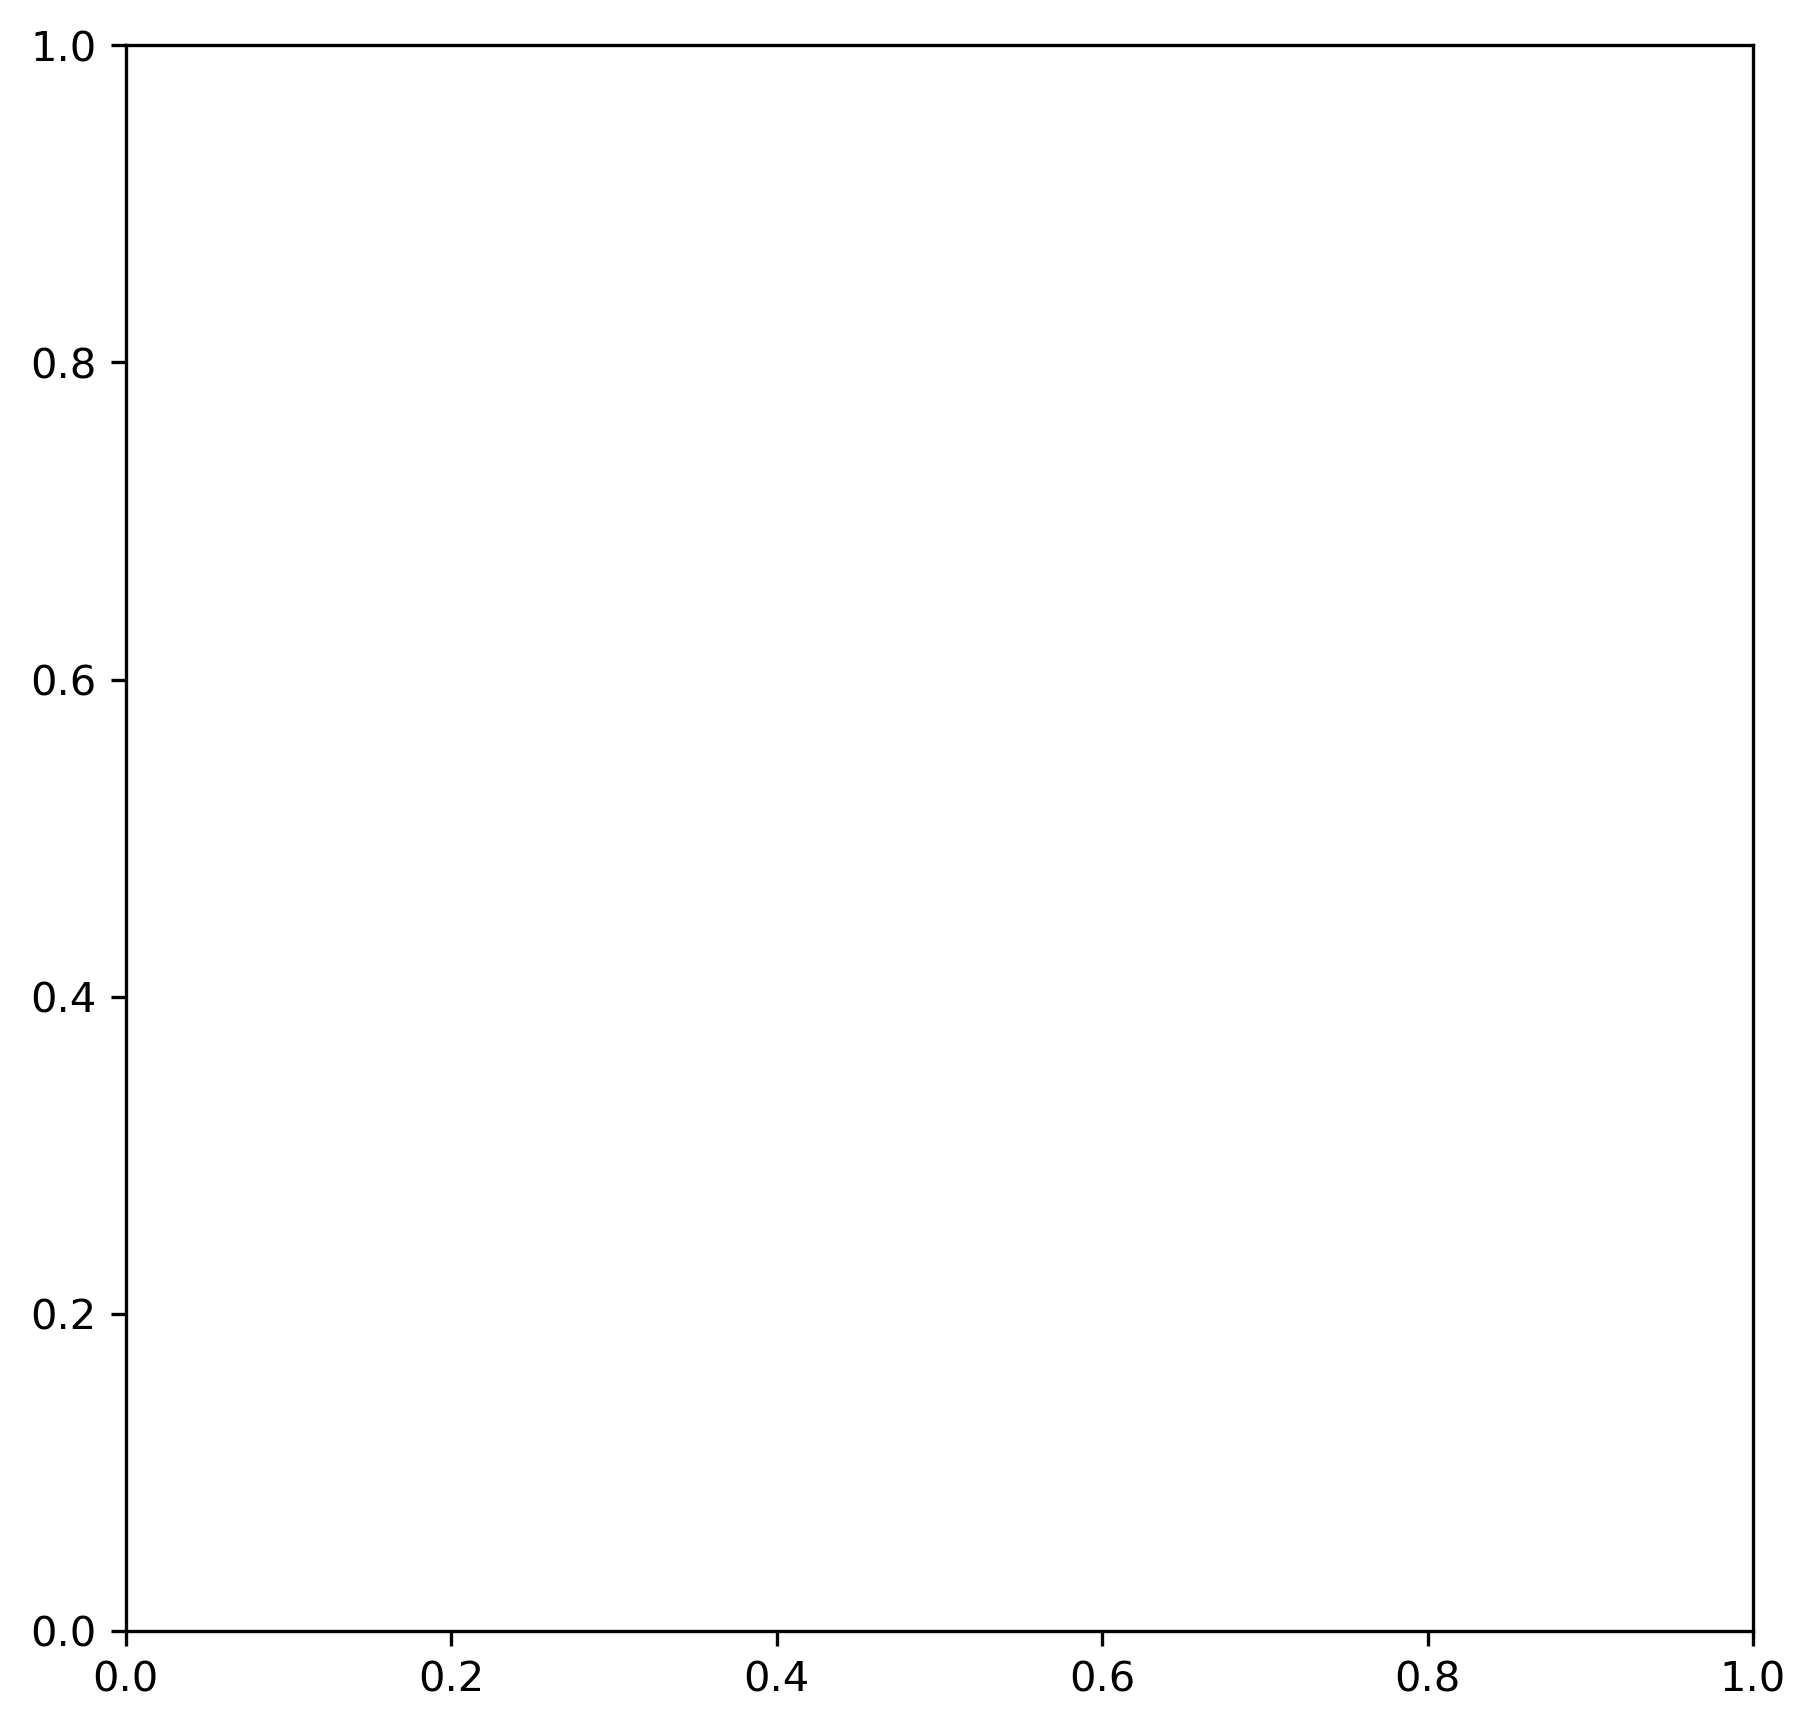

In [17]:
xlims = [0.1, 1e1]
ylims = [0.1, 1e1]

xline = np.arange(xlims[0], xlims[-1]+1)

fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=300)

In [18]:
ax.scatter(chl_insitu, chl_sat, facecolor='None', edgecolor='b', label='Match ups')
ax.plot(xline, myExpFunc(xline, *popt), 'r-', label="RMA LinRegress")
ax.plot(xline, xline, color='black', label='1:1 line');

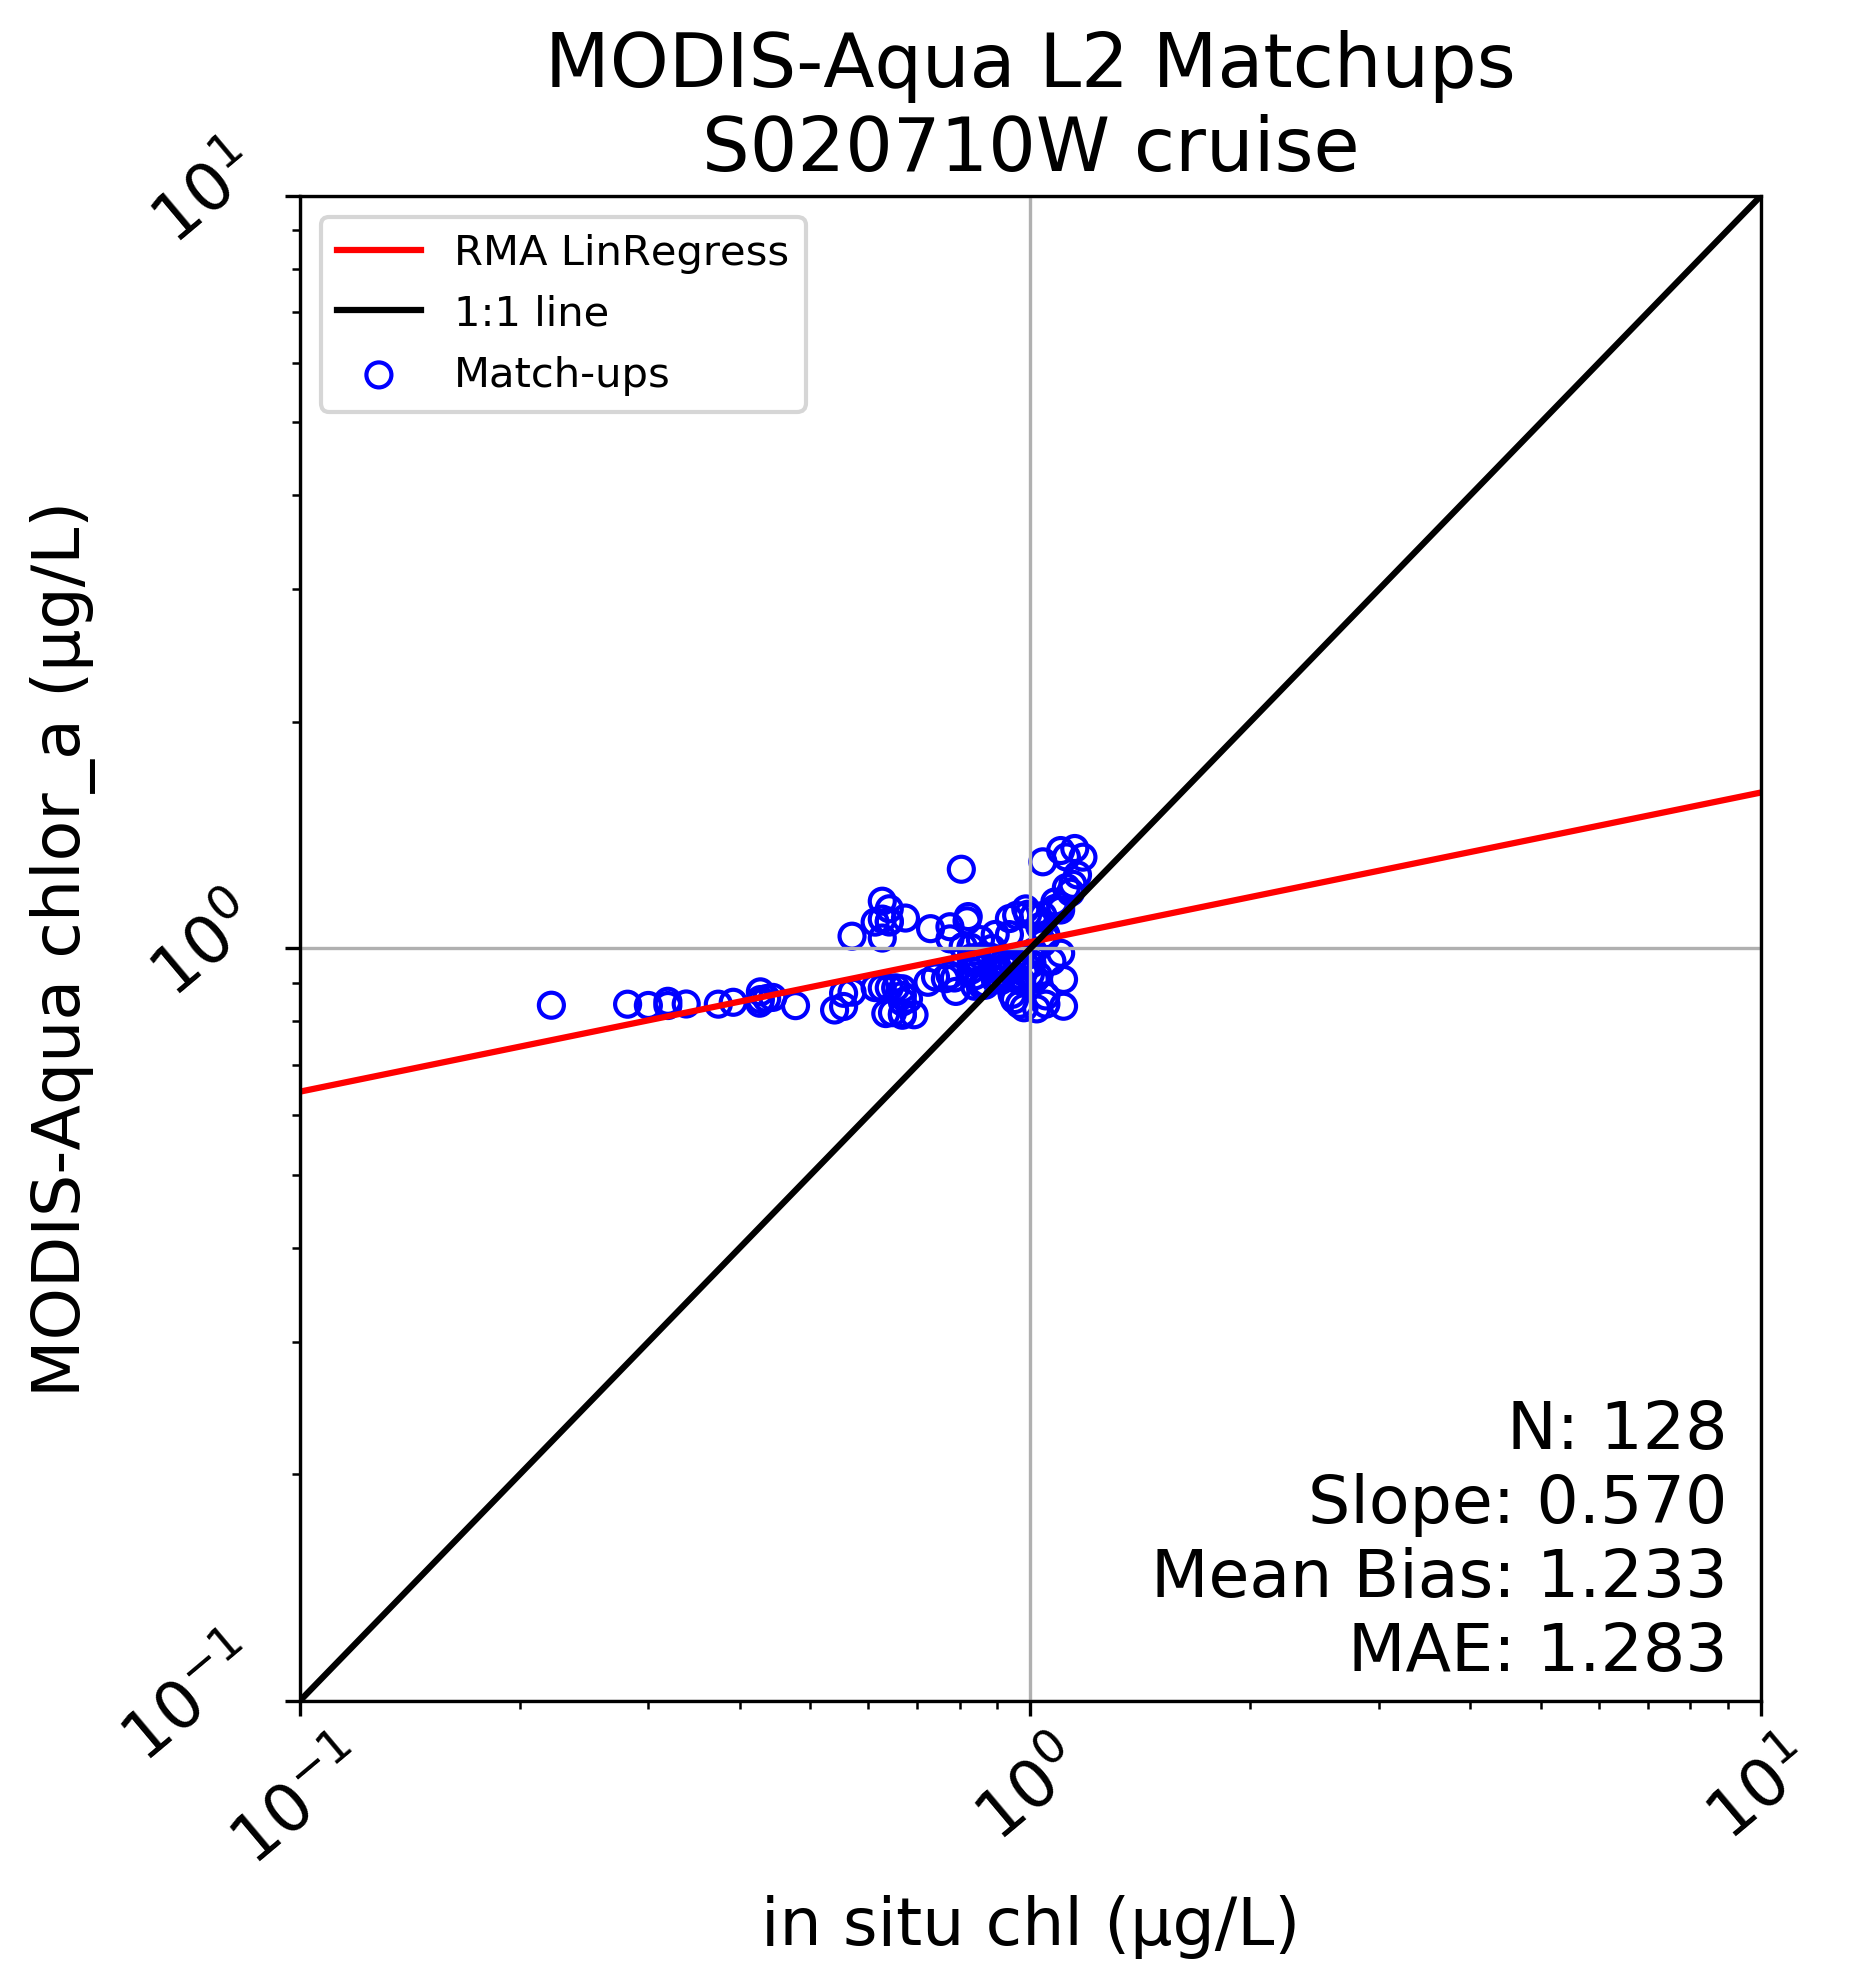

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=300)
fig.tight_layout(rect=[0.1,0.1,.9,.9])

ax.scatter(chl_insitu, chl_sat, facecolor='None', edgecolor='b', label='Match-ups')
ax.plot(xline, myExpFunc(xline, *popt), 'r-', label='RMA LinRegress')
ax.plot(xline, xline, color='black', label='1:1 line');

ax.grid(True)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xscale('log')
ax.set_yscale('log')

plt.xticks(rotation=40, ha='center', va='top', fontsize=16)
plt.yticks(rotation=40, ha='right', va='center', fontsize=16)

ax.set_xlabel(u'in situ chl (\u03bcg/L)', fontsize=16)
ax.set_ylabel(u'MODIS-Aqua chlor_a (\u03bcg/L)', fontsize=16)
ax.set_title('MODIS-Aqua L2 Matchups\nS020710W cruise', fontsize=18)

ax.legend(loc='upper left')

ax.text(xlims[-1]-1, ylims[0]+0.01, 
        'N: {:d}\nSlope: {:.3f}\nMean Bias: {:.3f}\nMAE: {:.3F}'.format(len(chl_insitu),
        slope, bias, mae), fontsize=16, horizontalalignment='right')

fig.savefig('./figs/fig1_scatter.png')

<center><img src='./figs/fig1_scatter.png', width=800px, height=800px></center>

## Plot 2: matchup data as a 2-dim histogram (joint-PDF)
* Create and fill a 50x50 grid-space with matchup density

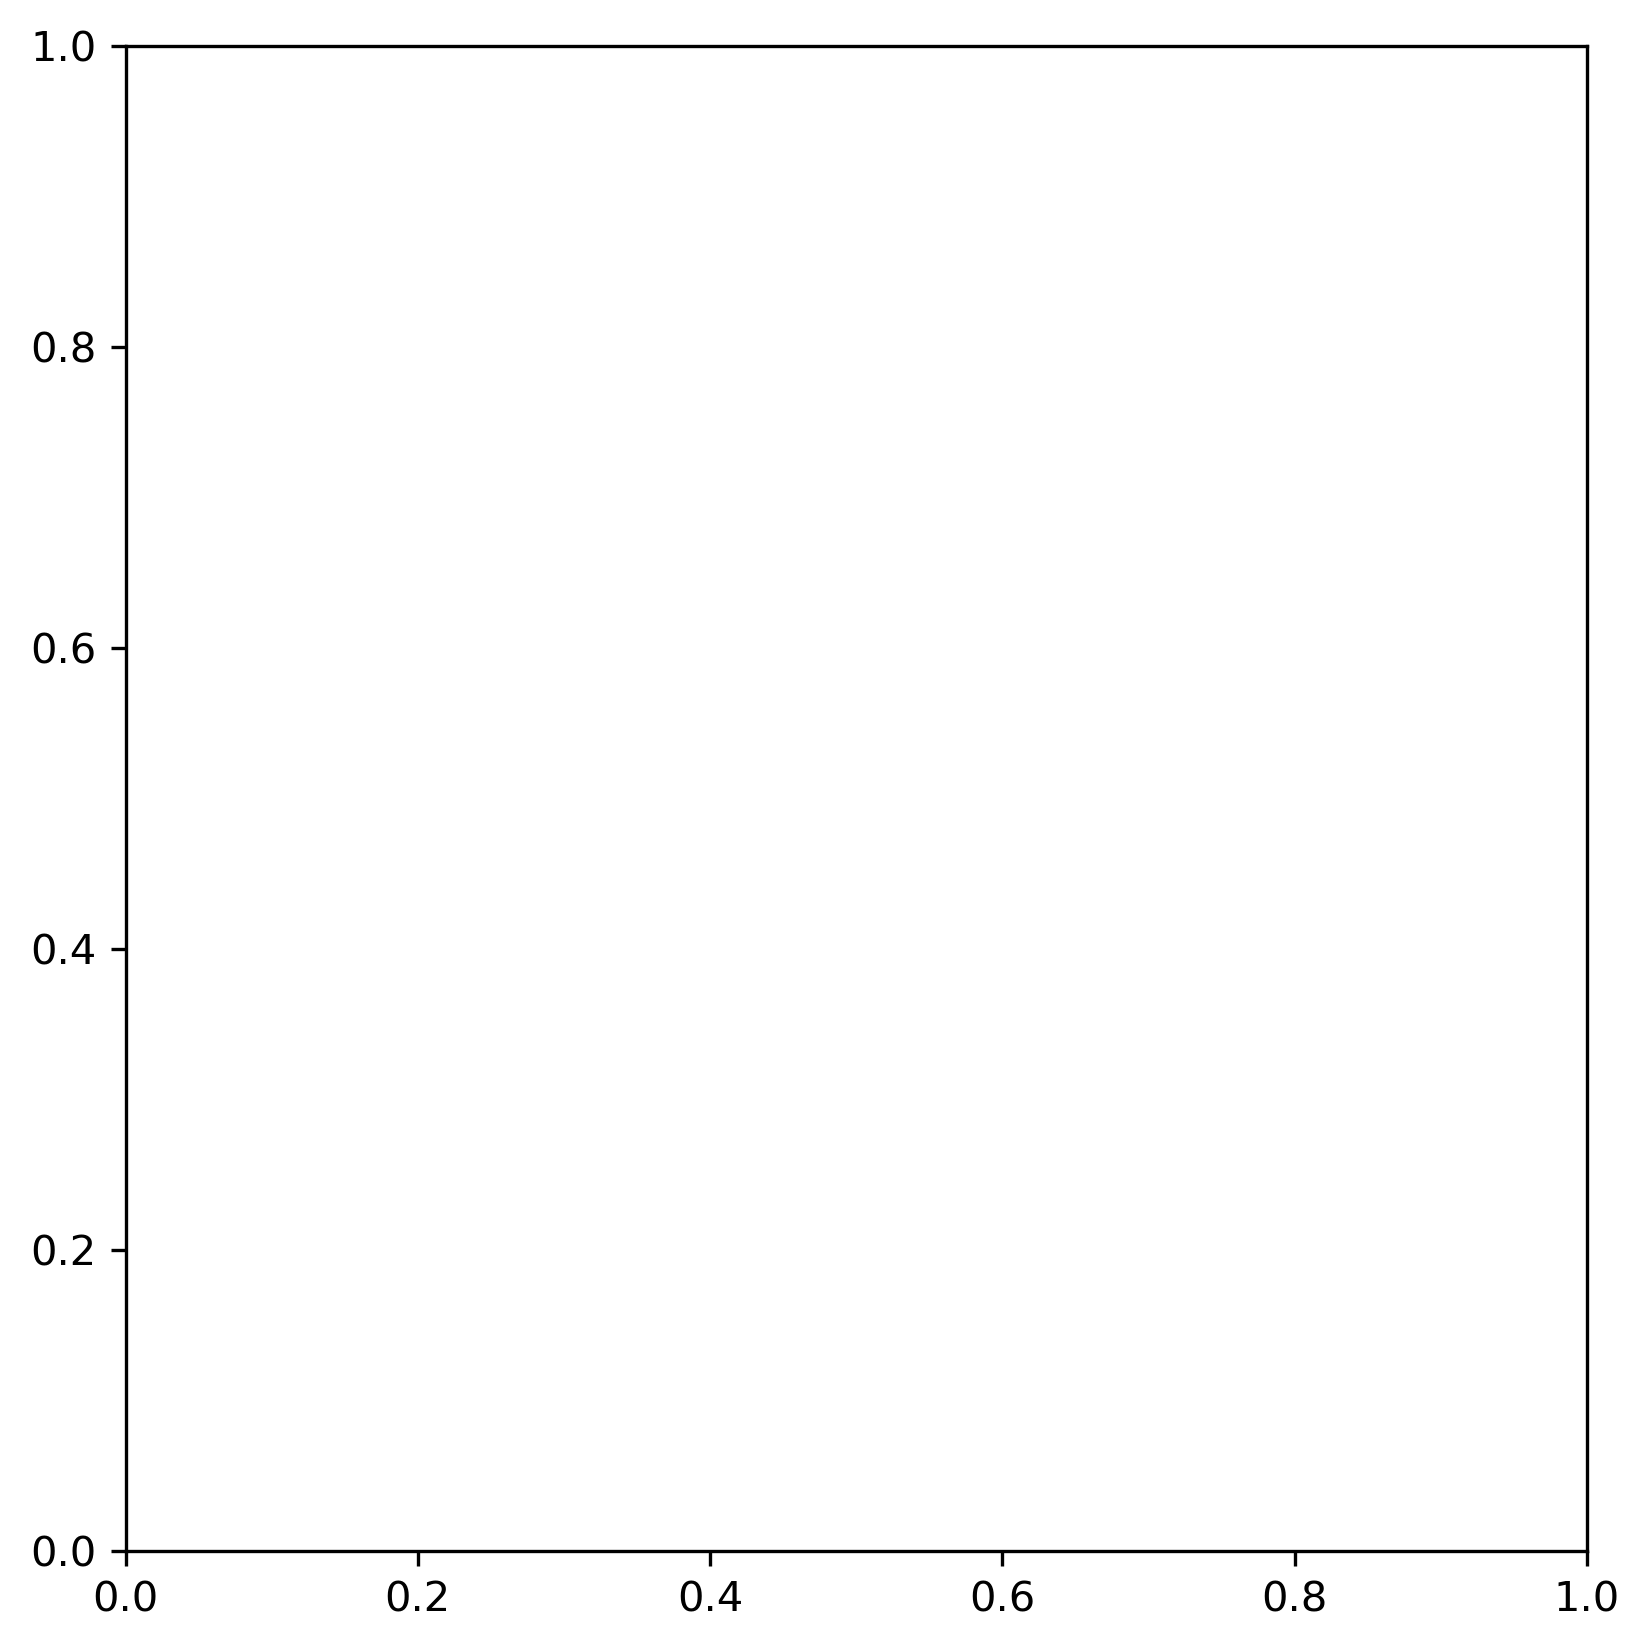

In [22]:
cm = cmocean.cm.matter
cm.set_under(color='white')

fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=300)
fig.tight_layout(rect=[0.1,0.1,.9,.9])

In [23]:
xbins = np.logspace(np.log10(xlims[0]), np.log10(xlims[1]), num=50)
ybins = np.logspace(np.log10(ylims[0]), np.log10(ylims[1]), num=50)

h,xedges,yedges = np.histogram2d(chl_insitu, chl_sat, bins=[xbins, ybins])
X,Y = np.meshgrid(xedges, yedges)

p1 = ax.pcolormesh(X, Y, h.T, cmap=cm, vmin=1e-5)
ax.plot(xbins, myExpFunc(xbins, *popt), 'k--', label="RMA LinRegress")
ax.plot(xbins, xbins, color='black', label="1:1 line");

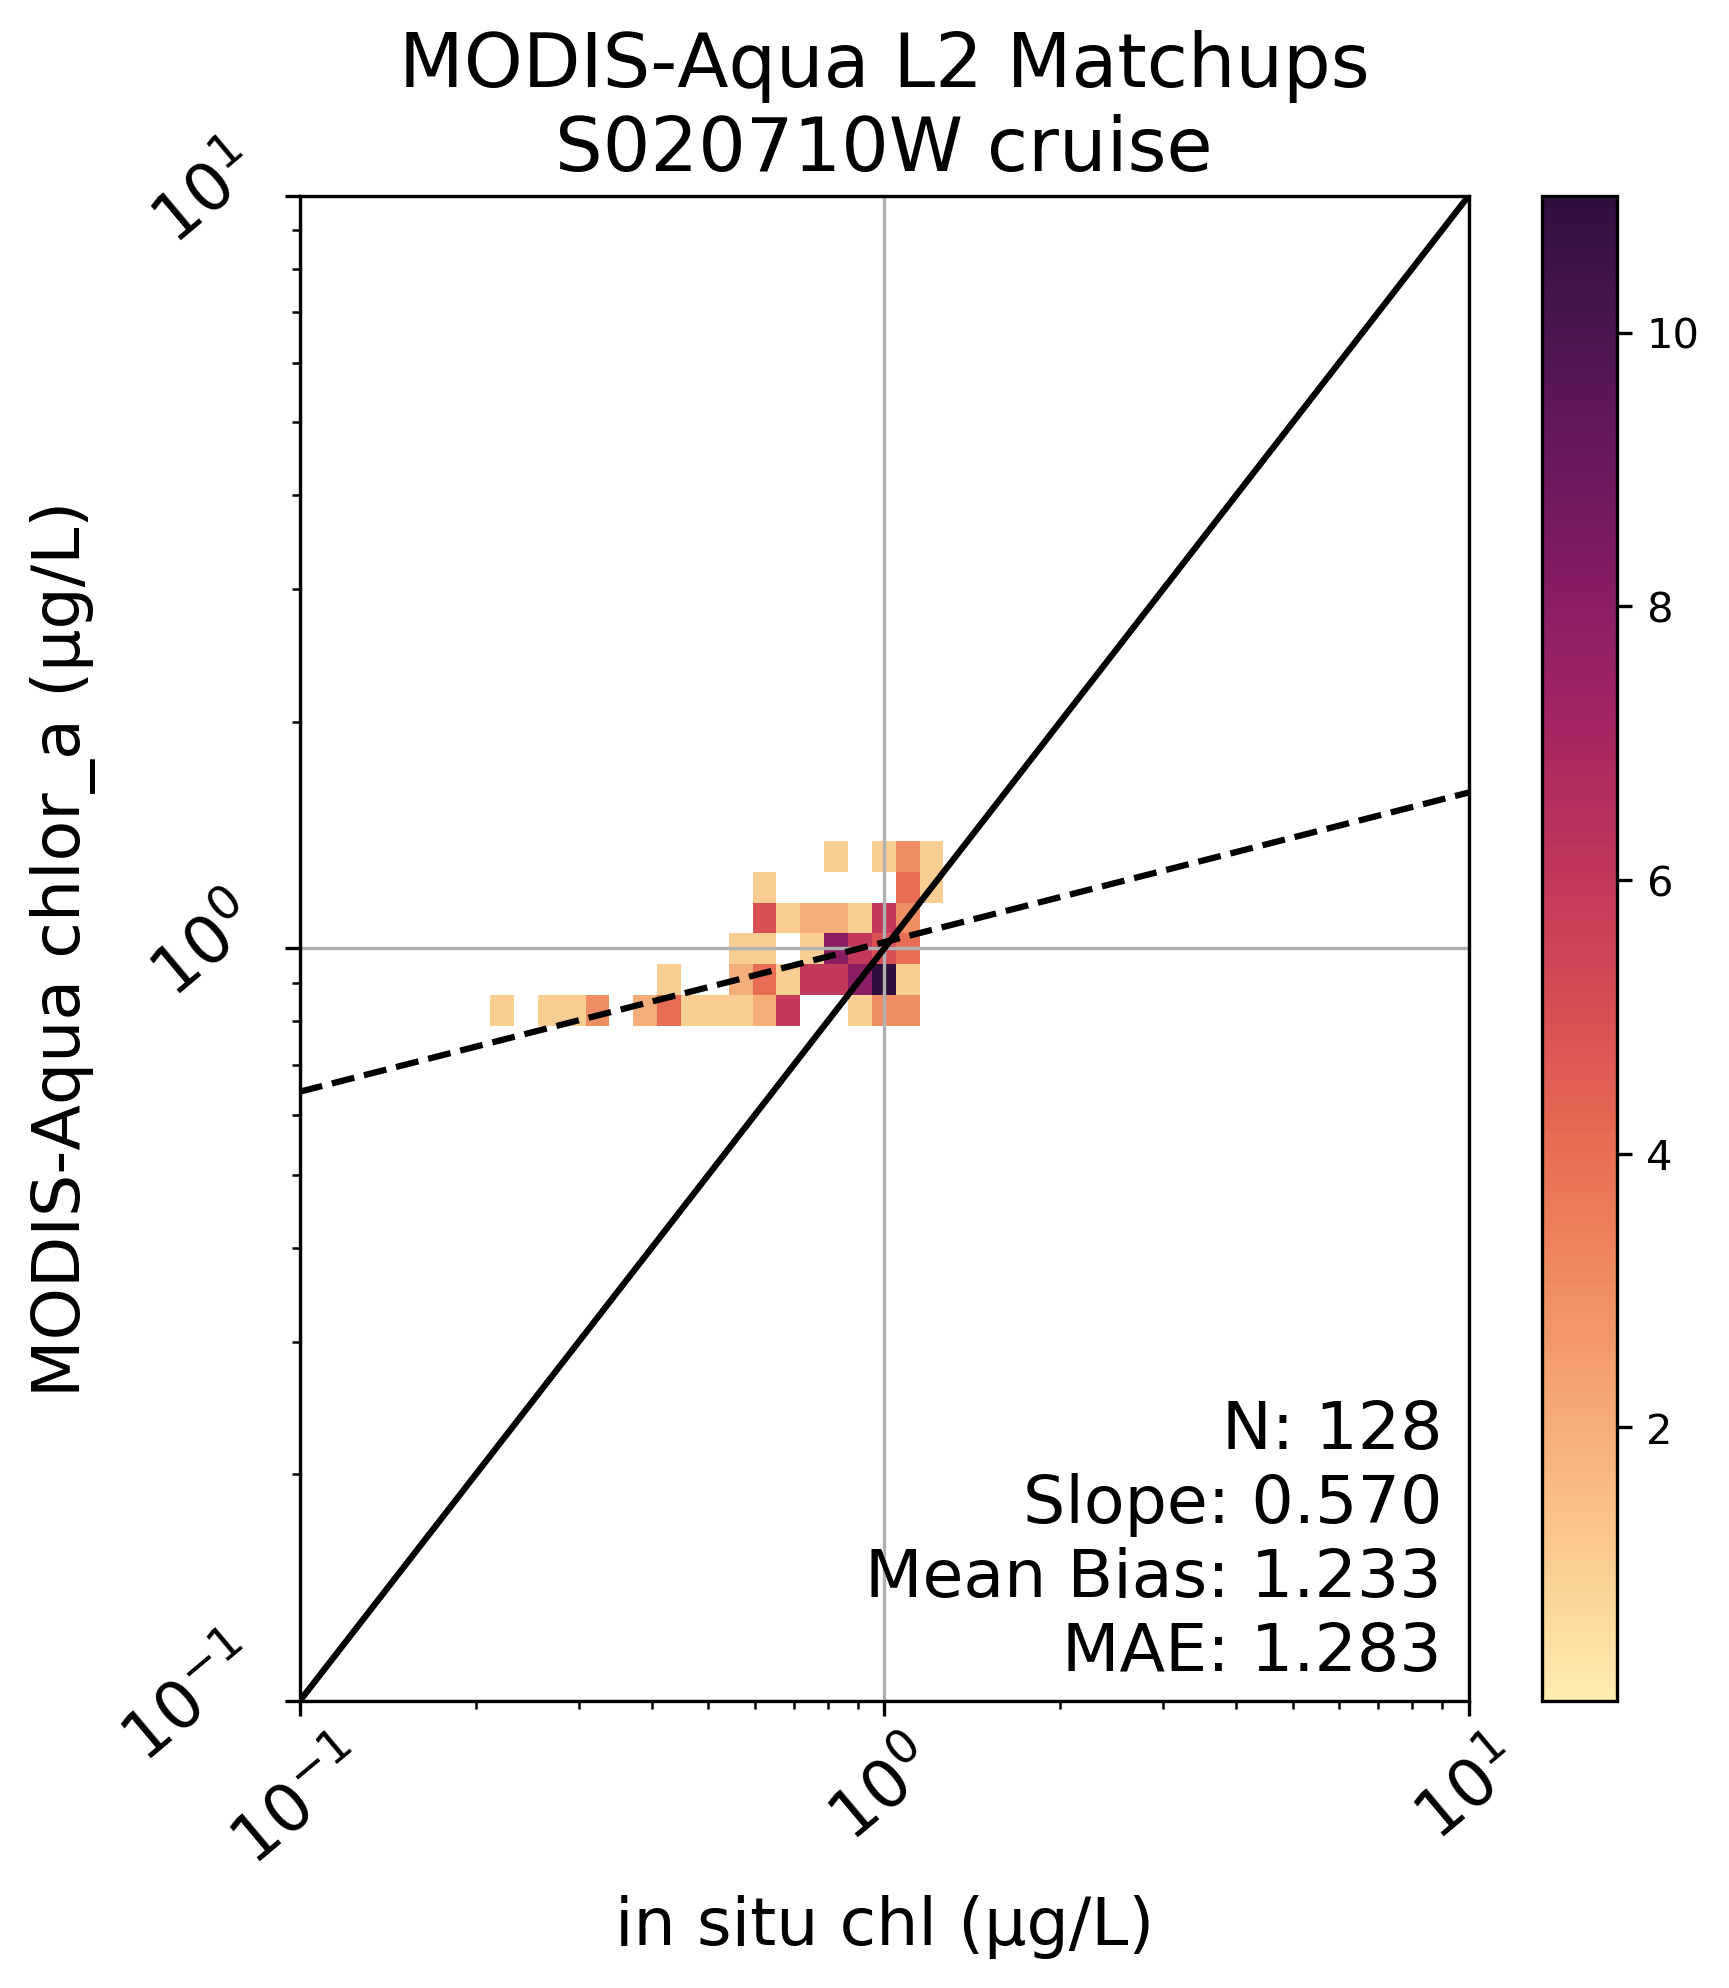

In [24]:
fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=300)
fig.tight_layout(rect=[0.1,0.1,.9,.9])

p1 = ax.pcolormesh(X, Y, h.T, cmap=cm, vmin=1e-5)
ax.plot(xbins, myExpFunc(xbins, *popt), 'k--', label="({0:.3f}*x^{1:.3f})".format(*popt))
ax.plot(xbins, xbins, color='black')

ax.grid(True)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xscale('log')
ax.set_yscale('log')

plt.colorbar(p1, ax=ax)
plt.xticks(rotation=40, ha='center', va='top', fontsize=16)
plt.yticks(rotation=40, ha='right', va='center', fontsize=16)

ax.set_xlabel(u'in situ chl (\u03bcg/L)', fontsize=16)
ax.set_ylabel(u'MODIS-Aqua chlor_a (\u03bcg/L)', fontsize=16)
ax.set_title('MODIS-Aqua L2 Matchups\nS020710W cruise', fontsize=18)

ax.text(xlims[-1]-1, ylims[0]+0.01, 
        'N: {:d}\nSlope: {:.3f}\nMean Bias: {:.3f}\nMAE: {:.3F}'.format(len(chl_insitu),
        slope, bias, mae), fontsize=16, horizontalalignment='right')

plt.show()
fig.savefig('./figs/fig2_jpdf.png')

<center><img src='./figs/fig2_jpdf.png', width=800px, height=800px></center>

# Summary
* Why I love Python
    * Language is open source & well-supported
    * Code is shareable & reproducible
    * Scripts are efficient & versatile

* Many applications to Ocean Color
    * Find & download data
    * Create matchups
    * Read/write or analyze/plot data

# Thank you!
### Questions?
joel.scott@nasa.gov
<br>
<div><img style="float: left;" src='./figs/oel_meatball.png', width=600px></div>